In [66]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ''

from encoding_information.gpu_utils import limit_gpu_memory_growth  
limit_gpu_memory_growth()

filters_path = '/home/hpinkard_waller/data/ideal_figure_items/filters'

# find the names of all npy files
filter_files = os.listdir(filters_path)
filter_files = [f for f in filter_files if f.endswith('.npy')]
indices = [int(f.split('_')[-1][:-4]) for f in filter_files]
indices = np.array(indices)

epoch_indices = indices[np.argsort(indices)]

epoch_indices


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


array([   0,  196,  391,  587,  782,  978, 1173, 1369, 1564, 1760, 1955,
       2150, 2346, 2541, 2737, 2932, 3128, 3323, 3519, 3714])

3944.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


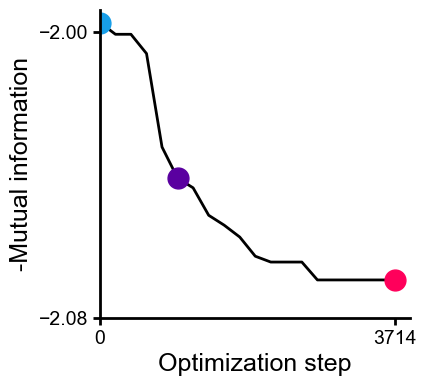

In [82]:
import numpy as np  
from cleanplots import *

initial = 0
intermediate = 978
final = 3714

val_loss_path = '/home/hpinkard_waller/data/ideal_figure_items/val_losses.npy'

# load the validation losses

val_losses = np.load(val_loss_path)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(epoch_indices, val_losses, label='Initial', color='k', linewidth=2)
# plot points at initial, intermediate, and final
ax.plot(initial, val_losses[initial], 'o', markersize=15)
ax.plot(intermediate, val_losses[np.where(epoch_indices == intermediate)[0][0]], 'o', markersize=15)
ax.plot(final, val_losses[np.where(epoch_indices == final)[0][0]], 'o', markersize=15)

ax.set(
    xlim=(0, None), 
    yticks=[-2.08, -2],
     xticks=[0, final], 
    xlabel='Optimization step', ylabel='-Mutual information')
clear_spines(ax)

fig.savefig('/home/hpinkard_waller/figures/IDEAL/ideal_loss.pdf', transparent=True)



######
#####
# Create a series of PNG files for each frame of the animation
    
# Get axis limits and ticks from the existing plot
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Directory to save the plots
save_dir = '/home/hpinkard_waller/figures/IDEAL/loss_curve_frames/'
import os
os.makedirs(save_dir, exist_ok=True)

# Number of epochs or optimization steps
num_epochs = len(val_losses)
# epoch_indices = np.arange(num_epochs)

# Loop over time points to create individual plots
for k in range(1, num_epochs + 1):
    # Create a new figure and axis for each frame
    fig_frame, ax_frame = plt.subplots(1, 1, figsize=(4, 4))
    
    # Plot the loss curve up to the k-th point
    ax_frame.plot(epoch_indices[:k], val_losses[:k], color='k', linewidth=3)
    # plot a black dot on the current point
    ax_frame.plot(epoch_indices[k-1], val_losses[k-1], 'o', markersize=15, color='k')
    
    # Set axis limits and labels from the existing plot
    ax_frame.set_xlim(xlim)
    ax_frame.set_ylim(ylim)
    ax_frame.set(
        yticks=[],
        xticks=[],
        xlabel=None,
        ylabel=None
    )
    clear_spines(ax_frame)
    
    # Save the figure as a PNG
    filename = f'plot_{k:04d}.png'  # Zero-padded filename
    filepath = os.path.join(save_dir, filename)
    fig_frame.savefig(filepath, transparent=True, dpi=300)
    plt.close(fig_frame)  # Close the figure to free up memory

# Save as a GIF with 7fps using ImageMagick
!convert -dispose 2 -delay 15 -loop 0 /home/hpinkard_waller/figures/IDEAL/loss_curve_frames/plot_*.png /home/hpinkard_waller/figures/IDEAL/loss_curve.gif



In [88]:
from tqdm import tqdm


# make a dict mapping epoch to filter 
# the file patterns is ideal_iteration_0.npy    
epoch_to_filter = { i:np.load(os.path.join(filters_path, f'ideal_iteration_{i}.npy')) for i in epoch_indices}

epoch_to_filter[0].shape


##
def get_filter_image(filter_array):
    """
    Plots the filter pattern as an RGB image.

    Parameters:
    - filter_array: numpy array of shape (H, W, 4), where the last dimension
      represents the mutually exclusive RGBW channels.
    """
    # Define RGB values for each channel: Red, Green, Blue, White
    color_map = np.array([
        [1, 0, 0],  # Red
        [0, 1, 0],  # Green
        [0, 0, 1],  # Blue
        [1, 1, 1],  # White
    ])

    # Get the index of the active channel at each pixel
    active_channel = np.argmax(filter_array, axis=-1)
    
    # Map the active channels to RGB colors
    image = color_map[active_channel] * 255
    
    return image


from PIL import Image
# iterate through all the epochs and plot the filters and save them as a series of pngs
# delete the old pngs first
import shutil
if os.path.exists('/home/hpinkard_waller/figures/IDEAL/filters_png'):
    shutil.rmtree('/home/hpinkard_waller/figures/IDEAL/filters_png')
os.makedirs('/home/hpinkard_waller/figures/IDEAL/filters_png')

upsample = 16
for i, (epoch, filter_array) in enumerate(tqdm(epoch_to_filter.items())):
    # print(epoch)
    filter = get_filter_image(filter_array)
    filter = np.repeat(np.repeat(filter, upsample, axis=0), upsample, axis=1)
    # use PIL to save the image
    im = Image.fromarray(filter.astype(np.uint8))
    # make a path with leading zeros
    path = f'/home/hpinkard_waller/figures/IDEAL/filters_png/epoch_{i:04d}.png'
    im.save(path)
    

    

100%|██████████| 20/20 [00:00<00:00, 1386.96it/s]


In [89]:
# remove existing video
if os.path.exists('/home/hpinkard_waller/figures/IDEAL/filters.mp4'):
    os.remove('/home/hpinkard_waller/figures/IDEAL/filters.mp4')
# make a GIF
!convert -dispose 2 -delay 15 -loop 0 /home/hpinkard_waller/figures/IDEAL/filters_png/epoch_*.png /home/hpinkard_waller/figures/IDEAL/filters.gif

# Use ffmpeg to make a video
# !ffmpeg -r 6.6666666 -i /home/hpinkard_waller/figures/IDEAL/filters_png/epoch_%d.png -vcodec libx264 -pix_fmt yuv420p /home/hpinkard_waller/figures/IDEAL/filters.mp4

4322.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [105]:
from encoding_information.datasets import ColorFilterArrayDataset
from cleanplots import *
from tqdm import tqdm

tile_size = 128

dataset = ColorFilterArrayDataset('/home/hpinkard_waller/data/four_channel_images.zarr', tile_size=tile_size)
indices = [76398, 83209, 79983]
center_square_size = 24



In [108]:
measurements.shape

(128,)

In [114]:
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import shutil


rescale_for_display = lambda x: np.clip((x / 255 * 3) ** (1 / 2.2), 0, 1)


# Create the directory for measurement images
measurements_png_path = '/home/hpinkard_waller/figures/IDEAL/measurements_png'
if os.path.exists(measurements_png_path):
    shutil.rmtree(measurements_png_path)
os.makedirs(measurements_png_path)

upsample = 16  # Same upsampling factor as in filter image generation

# Iterate over each epoch and corresponding filter array
for i, (epoch, filter_array) in enumerate(tqdm(epoch_to_filter.items())):
    # Convert the filter array from one-hot encoding to integer indices (0, 1, 2, 3)
    filter_matrix = np.argmax(filter_array, axis=-1)  # Shape: (H, W)

    # Generate measurements using the filter matrix
    # Note: 'dataset', 'indices', and 'dataset.rescale_fraction' should be defined in your environment
    measurements = dataset.get_measurements(mean=1000, bias=0, tile_indices=indices, filter_matrix=filter_matrix)

    # Rescale measurements according to your dataset's rescale fraction
    measurements = measurements / dataset.rescale_fraction

    # Loop over each measurement
    for m_idx, measurement in enumerate(measurements):
        # Get the shape of the measurement
        h, w = measurement.shape

        # Tile the filter matrix to match the measurement dimensions
        filter_h, filter_w = filter_matrix.shape
        tile_factor_h = h // filter_h
        tile_factor_w = w // filter_w
        tiled_filter = np.tile(filter_matrix, (tile_factor_h, tile_factor_w))

        # Create masks for each color channel
        red_mask = tiled_filter == 0
        green_mask = tiled_filter == 1
        blue_mask = tiled_filter == 2
        white_mask = tiled_filter == 3

        # Initialize an array for the colored measurement
        colored_measurement = np.zeros((h, w, 3))

        # Assign measurements to each color channel
        colored_measurement[..., 0] = measurement * red_mask  # Red channel
        colored_measurement[..., 1] = measurement * green_mask  # Green channel
        colored_measurement[..., 2] = measurement * blue_mask  # Blue channel

        # For white pixels, set all RGB channels to the measurement value
        for c in range(3):
            colored_measurement[..., c][white_mask] = measurement[white_mask]

        # Crop to central square
        edge_crop_h = (h - center_square_size) // 2
        edge_crop_w = (w - center_square_size) // 2
        cropped_measurement = colored_measurement[
            edge_crop_h : h - edge_crop_h, edge_crop_w : w - edge_crop_w
        ]


        # Upsample the image for better visualization
        colored_measurement_upsampled = np.repeat(
            np.repeat(cropped_measurement, upsample, axis=0), upsample, axis=1
        )

        # Rescale the image data for display (0-255 uint8 range)
        image_uint8 = (255 * rescale_for_display(colored_measurement_upsampled)).astype(np.uint8)

        # Create a subdirectory for this measurement index if it doesn't exist
        measurement_dir = os.path.join(measurements_png_path, f'measurement_{m_idx}')
        os.makedirs(measurement_dir, exist_ok=True)

        # Save the image
        im = Image.fromarray(image_uint8)
        # Use a filename that includes the epoch index
        path = os.path.join(measurement_dir, f'epoch_{i:04d}.png')
        im.save(path)


100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


In [115]:
!convert -dispose 2 -delay 15 -loop 0 /home/hpinkard_waller/figures/IDEAL/measurements_png/measurement_0/epoch_*.png /home/hpinkard_waller/figures/IDEAL/measurements_png/measurement_0.gif
!convert -dispose 2 -delay 15 -loop 0 /home/hpinkard_waller/figures/IDEAL/measurements_png/measurement_1/epoch_*.png /home/hpinkard_waller/figures/IDEAL/measurements_png/measurement_1.gif
!convert -dispose 2 -delay 15 -loop 0 /home/hpinkard_waller/figures/IDEAL/measurements_png/measurement_2/epoch_*.png /home/hpinkard_waller/figures/IDEAL/measurements_png/measurement_2.gif

8975.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8982.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
8989.72s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [118]:
# Plor the measurement corresponding to IDEAL initialization

# load data/ideal/patch_0.npy

patch = np.load('/home/hpinkard_waller/data/ideal/patch_2.npy')

# Rescale the image data for display (0-255 uint8 range)
image_uint8 = (255 * rescale_for_display(patch)).astype(np.uint8)

# Save the image
im = Image.fromarray(image_uint8)
# Use a filename that includes the epoch index
path = '/home/hpinkard_waller/figures/IDEAL/patch_2_recon_initial.png'
im.save(path)